In [1]:
import os
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl

In [2]:
%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
s=os.getcwd()
print(s)
pd.set_option('display.max_columns', 10)

C:\Users\sugan


In [4]:
# Loading data set
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
sales_train = pd.read_csv('sales_train.csv')
sales_test = pd.read_csv('sales_test.csv')

In [5]:
train = sales_train.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(cats, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [6]:
train.shape

(2935849, 10)

In [7]:
print(train.describe(include="all"))

              date  date_block_num    shop_id    item_id  item_price  \
count      2935849      2935849.00 2935849.00 2935849.00  2935849.00   
unique        1034             nan        nan        nan         nan   
top     28.12.2013             nan        nan        nan         nan   
freq          9434             nan        nan        nan         nan   
mean           NaN           14.57      33.00   10197.23      890.85   
std            NaN            9.42      16.23    6324.30     1729.80   
min            NaN            0.00       0.00       0.00       -1.00   
25%            NaN            7.00      22.00    4476.00      249.00   
50%            NaN           14.00      31.00    9343.00      399.00   
75%            NaN           23.00      47.00   15684.00      999.00   
max            NaN           33.00      59.00   22169.00   307980.00   

        item_cnt_day                                          item_name  \
count     2935849.00                                        

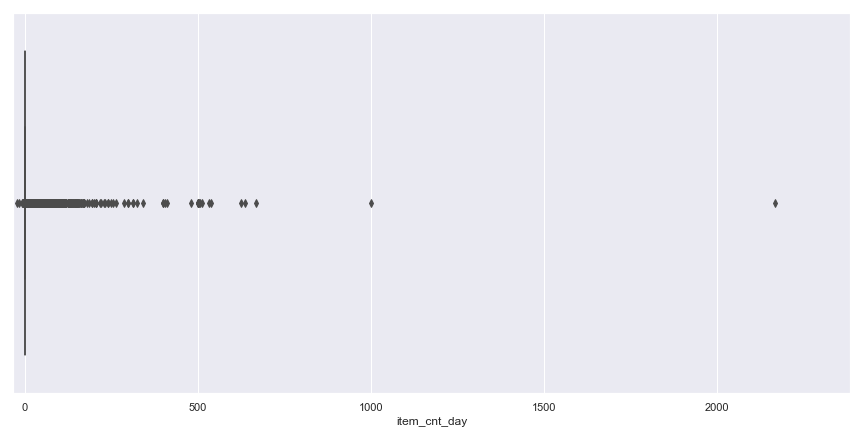

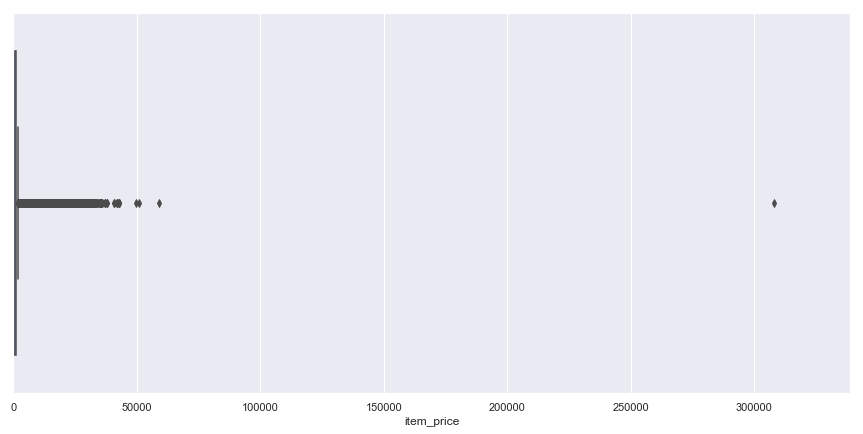

In [8]:
plt.figure(figsize=(15,7))
plt.xlim(train.item_cnt_day.min()*1.5, train.item_cnt_day.max()*1.1)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(15,7))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [9]:
median = train.item_price.median()
train.loc[train.item_price<0, 'item_price'] = median
train = train[train.item_price<100000]

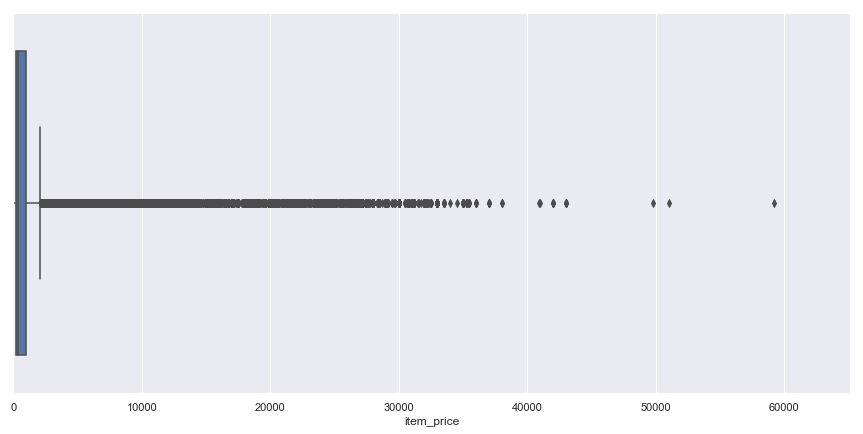

In [10]:
plt.figure(figsize=(15,7))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [12]:
test_shop_ids = sales_test['shop_id'].unique()
test_item_ids = sales_test['item_id'].unique()
print(test_item_ids.shape)
new_train = train[train['shop_id'].isin(test_shop_ids)]
print(train.shape)
print(new_train.shape)
new_train = new_train[new_train['item_id'].isin(test_item_ids)]
print(new_train.shape)

(5100,)
(2935848, 10)
(2413245, 10)
(1224439, 10)


In [14]:
month_train = new_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [15]:
month_train = month_train.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)

In [16]:
print(month_train.head())

               date  date_block_num  shop_id  item_category_id  item_id  \
21124    01.01.2013               0       28                65    16135   
54645    01.01.2013               0        7                55     8012   
106792   01.01.2013               0       37                30     2703   
54571    01.01.2013               0        7                55    10786   
47497    01.01.2013               0       15                30     2308   
45604    01.01.2013               0       15                55    18669   
56913    01.01.2013               0       14                21     1523   
45676    01.01.2013               0       15                40    19080   
15689    01.01.2013               0       28                 5     5583   
108792   01.01.2013               0       46                40    16450   
10621    01.01.2013               0       19                62    13086   
56935    01.01.2013               0       14                28     1829   
15680    01.01.2013      

In [17]:
month_train = month_train.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

In [18]:
print(month_train.head())

  date_block_num shop_id item_category_id item_id item_price          \
                                                         sum    mean   
0              0       2                2    5572   10730.00 1532.86   
1              0       2                2    5643    4775.21 2387.61   
2              0       2                5    5583    1188.30  594.15   
3              0       2                6    7893    5970.00 1990.00   
4              0       2                6    7894    1490.00 1490.00   

  item_cnt_day             
           sum mean count  
0         9.00 1.29     7  
1         0.00 0.00     2  
2         2.00 1.00     2  
3         3.00 1.00     3  
4         1.00 1.00     1  


In [19]:
month_train.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [20]:
shop_ids = month_train['shop_id'].unique()
item_ids = month_train['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [21]:
month_train = pd.merge(empty_df, month_train, on=['date_block_num','shop_id','item_id'], how='left')
month_train.fillna(0, inplace=True)

In [22]:
month_train['year'] = month_train['date_block_num'].apply(lambda x: ((x//12) + 2013))
month_train['month'] = month_train['date_block_num'].apply(lambda x: (x % 12))

In [23]:
monthly_mean = month_train.groupby(['month'], as_index=False)['item_cnt'].mean()
monthly_sum = month_train.groupby(['month'], as_index=False)['item_cnt'].sum()
category_mean = month_train.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
category_sum = month_train.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
shop_mean = month_train.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
shop_sum = month_train.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

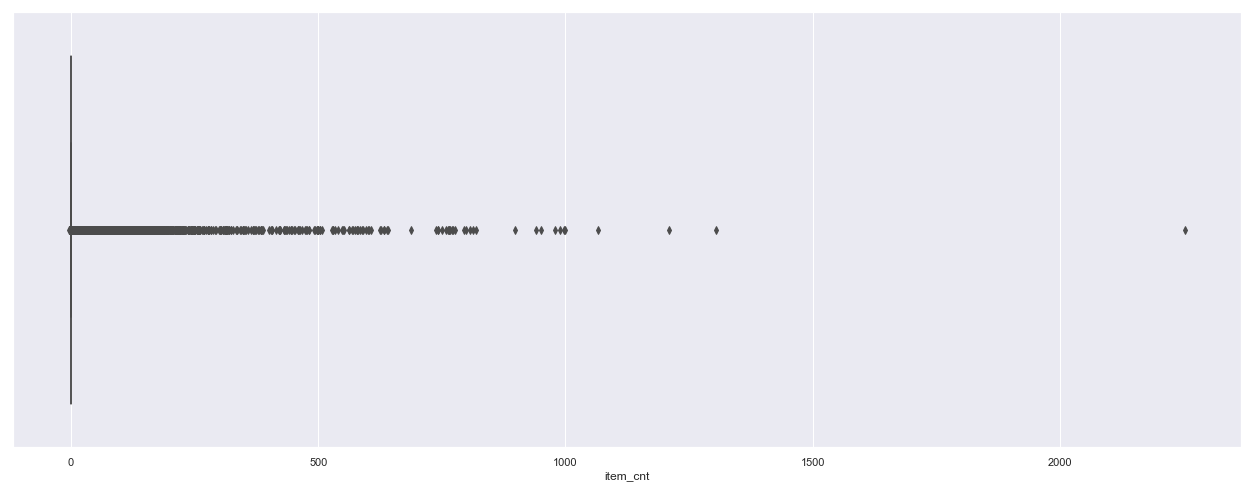

In [24]:
plt.figure(figsize=(22, 8))
sns.boxplot(x=month_train.item_cnt)
plt.show()

In [25]:
month_train.dtypes

date_block_num        int64
shop_id               int64
item_id               int64
item_category_id    float64
item_price          float64
mean_item_price     float64
item_cnt            float64
mean_item_cnt       float64
transactions        float64
year                  int64
month                 int64
dtype: object

In [26]:
month_train['item_cnt_month'] = month_train.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [27]:
month_train['item_price_unit'] = month_train['item_price'] // month_train['item_cnt']
month_train['item_price_unit'].fillna(0, inplace=True)

In [28]:
group_item_price = month_train.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
group_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

month_train = pd.merge(month_train, group_item_price, on='item_id', how='left')

In [29]:
month_train['price_increase'] = month_train['item_price'] - month_train['hist_min_item_price']
month_train['price_decrease'] = month_train['hist_max_item_price'] - month_train['item_price']

In [30]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    month_train[('item_cnt_%s' % function_name[i])] = month_train.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
month_train['item_cnt_std'].fillna(0, inplace=True)

In [31]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    month_train[ft_name] = month_train.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    month_train[ft_name].fillna(0, inplace=True)

In [32]:
month_train['item_trend'] = month_train['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    month_train['item_trend'] -= month_train[ft_name]

month_train['item_trend'] /= len(lag_list) + 1

In [33]:
train_set = month_train.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = month_train.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = month_train.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

In [34]:
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [35]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [37]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(sales_test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [38]:
sets = [X_train, X_validation, X_test]
           
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
X_test.fillna(X_test.mean(), inplace=True)

In [39]:
print(X_test.head().T)

                           0       1       2       3       4
shop_id                 5.00    5.00    5.00    5.00    5.00
item_id              5037.00 5320.00 5233.00 5232.00 5268.00
item_category_id       19.00    0.00   19.00    0.00    0.00
item_price            749.50    0.00 2997.00    0.00    0.00
mean_item_price       749.50    0.00  999.00    0.00    0.00
item_cnt                1.00    0.00    3.00    0.00    0.00
mean_item_cnt           1.00    0.00    1.00    0.00    0.00
transactions            1.00    0.00    3.00    0.00    0.00
year                 2015.00 2015.00 2015.00 2015.00 2015.00
month                   9.00    9.00    9.00    9.00    9.00
item_price_unit       749.00    0.00  999.00    0.00    0.00
hist_min_item_price     0.00    0.00    0.00    0.00    0.00
hist_max_item_price 25990.00 2495.00 7191.75 4796.00 2495.00
price_increase        749.50    0.00 2997.00    0.00    0.00
price_decrease      25240.50 2398.00 4194.75 4796.00 2398.00
item_cnt_min            

In [40]:
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [41]:

from sklearn.ensemble import RandomForestRegressor

In [42]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [43]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [44]:
from sklearn.metrics import mean_squared_error

In [45]:
print('Train RMSE:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Validation RMSE:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train RMSE: 1.9239633447826523
Validation RMSE: 2.582706635131372


In [47]:
prediction_df = pd.DataFrame(sales_test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = rf_test_pred
prediction_df.to_csv('pred_submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,0.93
1,1,0.16
2,2,1.42
3,3,0.16
4,4,0.16
5,5,0.93
6,6,2.06
7,7,0.16
8,8,2.06
9,9,0.16
